In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf 

%matplotlib inline

# 1. Create Data for Toy Problem

Assume that at every 10th element there is a little extra added to the series
Question: Can an RNN fit this?


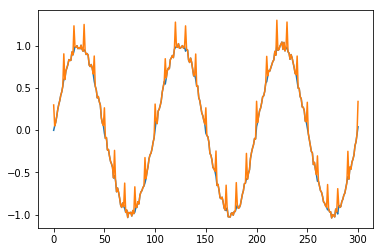

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x/T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2*T + 1)
    noise = ampl*np.random.uniform(low = -1.0, high = 1.0, size=len(x))
    return sin(x) + noise

T = 150
f = toy_problem(T)
plt.plot(f)
f[0::10] = f[0::10] + 0.3
plt.plot(f)
print('Assume that at every 10th element there is a little extra added to the series')
print('Question: Can an RNN fit this?')

# Setup configuration dictionary


In [3]:
def udic(x, ux):
    x.update(ux)
    return x



In [6]:
%%timeit -n 1 -r 1
print('x')

x
3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


0.522852
0.518866
0.516758
0.367499
0.152388
0.0672546
0.515752
0.478677
0.401479
0.513786
0.473639
0.394066
0.521325
0.518145
0.516443
0.384585
0.254852
0.219584
0.518642
0.507524
0.485765
0.518278
0.507776
0.487011
8min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


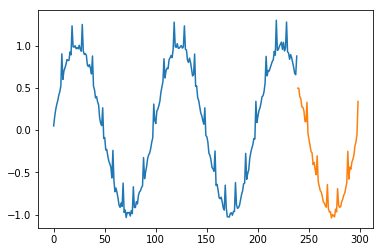

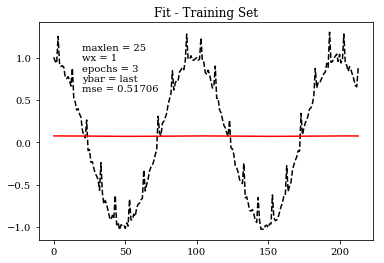

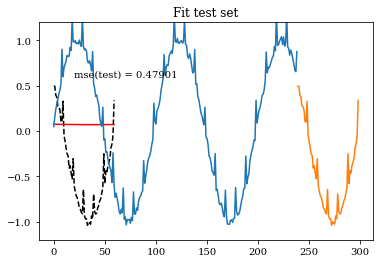

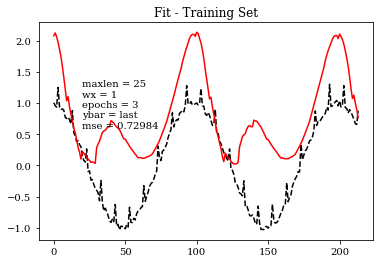

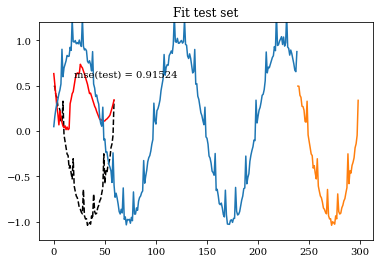

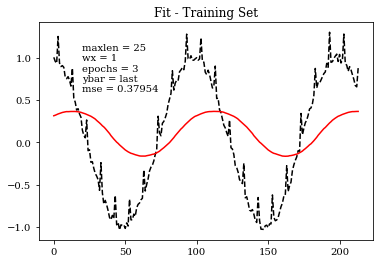

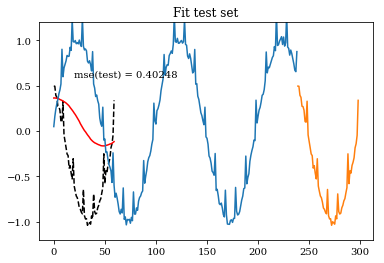

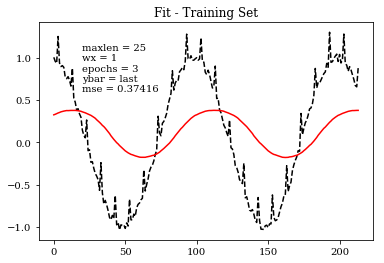

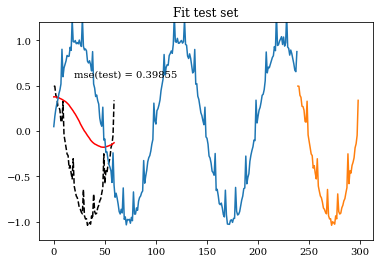

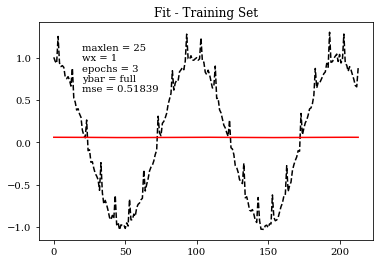

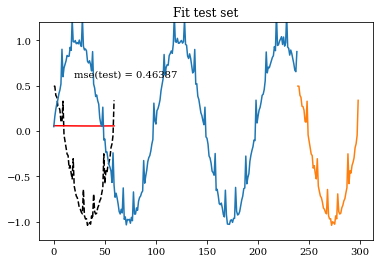

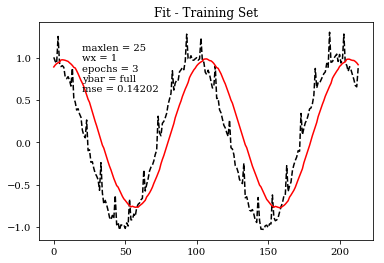

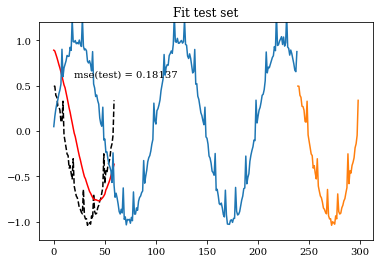

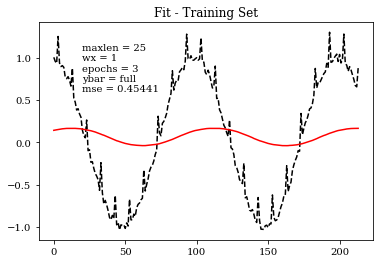

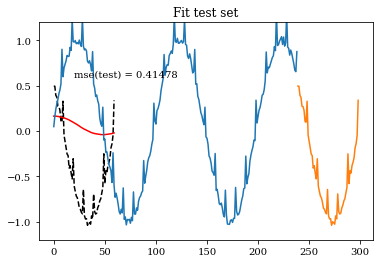

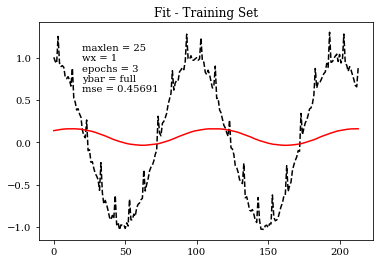

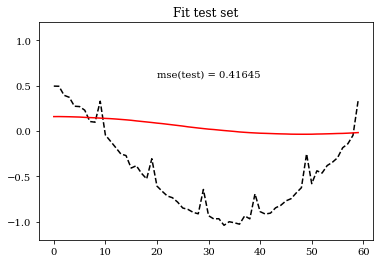

In [8]:
%%timeit -n 1 -r 1
config_dic = {'wx':10, 'ybar':'full', 'epochs':3, 'type':'LSTM'}


#run_lstm_model(udic(config_dic, {'type':'LSTM'}))
#run_cec_model(udic(config_dic, {'type':'CEC'}))
#run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple'}))
#run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget'}))
#
#run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last'}))
#run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last'}))
#run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last'}))
#run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last'}))

run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'last', 'wx':1}))
run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'last', 'wx':1}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'last', 'wx':1}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'last', 'wx':1}))

run_lstm_model(udic(config_dic, {'type':'LSTM', 'ybar':'full', 'wx':1}))
run_cec_model(udic(config_dic, {'type':'CEC', 'ybar':'full', 'wx':1}))
run_lstm_simple_model(udic(config_dic, {'type':'LSTM_simple', 'ybar':'full', 'wx':1}))
run_lstm_no_forget_model(udic(config_dic, {'type':'LSTM_no_forget', 'ybar':'full', 'wx':1}))

In [ ]:
run_cec_model(udic(config_dic, {'type':'CEC'}))

In [ ]:
config_dic.update({'type':'LSTA'})
config_dic

In [ ]:
run_lstm_no_forget_model(config_dic)

In [ ]:
run_lstm_simple_model(config_dic)

In [4]:
def run_lstm_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    Vi = tfM([n_hidden, n_hidden], 'Vi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    Vo = tfM([n_hidden, n_hidden], 'Vo')
    bo = tfB([n_hidden], 'bo')
    # FORGET GATE
    Uf = tfM([n_hidden, wx], 'Uf') 
    Wf = tfM([n_hidden, n_hidden], 'Wf')
    Vf = tfM([n_hidden, n_hidden], 'Vf')
    bf = tfB_forget([n_hidden], 'bf')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        f_i = tf.sigmoid(tfrs(Uf*x[:, i]) + tfrs(Wf*h_prev) + tfrs(Vf*c_prev) + bf)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + tfrs(Vi*c_prev) + bi)
        c_i = i_i*a_i + f_i*c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + tfrs(Vo*c_i) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'

In [5]:
def run_cec_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*c_prev, axis=1) + ba)
        c_i = a_i + c_prev
        clist.append(c_i)
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in clist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'



# Define Graph

In [6]:
def run_lstm_simple_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    bo = tfB([n_hidden], 'bo')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + bi)
        c_i = i_i*a_i + c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')
    return 'train_fig'+ config_str + '.png'

In [7]:
def run_lstm_no_forget_model(config_dic):
    config_str = '_'.join([ u + ':' + str(v) for u,v in  config_dic.items()])
    from scipy.linalg import hankel
    # hankel matrix takes 'first colum' and 'last row' as arguments
    wx = config_dic['wx']
    maxlen = 25
    first_column = list(range(wx))
    last_row = list(range(wx, f.shape[0]-1, 1))
    t_pos = hankel(first_column, last_row)
    X = f[t_pos]
    Y = f[t_pos[-1,:]+1]
    
    # Now arrange as a training and test set
    N_train = int(X.shape[1]*0.8)
    (X_train, Y_train) = (X[:, :N_train], Y[:N_train])
    (X_test, Y_test)   = (X[:, (N_train - maxlen):], Y[N_train:])
    plt.plot(Y_train)
    plt.plot(list(range(Y.shape[0])[N_train:]), Y_test)
    
    n_in = 1
    n_hidden = 20
    n_out = 1
    #maxlen = 25
    
    tf.reset_default_graph()
    # Input Parameters
    #x = tf.placeholder(tf.float32, shape=[None, maxlen])
    #ybar = tf.placeholder(tf.float32, shape=[None])
    x = tf.placeholder(tf.float32, shape=[wx, maxlen])
    ybar = tf.placeholder(tf.float32, shape=[maxlen])
    
    
    # TF Variables
    #y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out= n_out)
    #loss = loss(y, t)
    #train_step = training(loss)
    def tfM(shape, name):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name)
    
    def tfB(shape, name):
        return tf.Variable(tf.zeros(shape), dtype=tf.float32, name=name)
        
    def tfB_forget(shape, name):
        return tf.Variable(tf.ones(shape), dtype=tf.float32, name=name)
    
    V = tfM([n_hidden], 'V')
    c = tfB([n_out], 'b') 
    # INPUT GATE
    Ui = tfM([n_hidden, wx], 'Ui') 
    Wi = tfM([n_hidden, n_hidden], 'Wi')
    Vi = tfM([n_hidden, n_hidden], 'Vi')
    bi = tfB([n_hidden], 'bi')
    # OUTPUT GATE
    Uo = tfM([n_hidden, wx], 'Uo') 
    Wo = tfM([n_hidden, n_hidden], 'Wo')
    Vo = tfM([n_hidden, n_hidden], 'Vo')
    bo = tfB([n_hidden], 'bo')
    # ACTIVATION UNIT
    Ua = tfM([n_hidden, wx], 'Ua') 
    Wa = tfM([n_hidden, n_hidden], 'Wa')
    ba = tfB([n_hidden], 'ba')
    # Initialize lists
    h_prev = tf.zeros([n_hidden], dtype=tf.float32)
    c_prev = tf.zeros([n_hidden], dtype=tf.float32)
    
    hlist = []
    clist = []
    
    def tfrs(x):
        return tf.reduce_sum(x, axis=1)
    
    for i in range(maxlen):
        #a_i = tf.tanh(   tfrs(Ua*x[:, i]) + tfrs(Wa*h_prev) +                   ba) 
        a_i = tf.tanh(tf.reduce_sum(Ua*x[:, i], axis=1) + tf.reduce_sum(Wa*h_prev, axis=1) + ba)
        i_i = tf.sigmoid(tfrs(Ui*x[:, i]) + tfrs(Wi*h_prev) + tfrs(Vi*c_prev) + bi)
        c_i = i_i*a_i + c_prev
        o_i = tf.sigmoid(tfrs(Uo*x[:, i]) + tfrs(Wo*h_prev) + tfrs(Vo*c_i) + bo)
        h_i = o_i * tf.tanh(c_i)
        hlist.append(h_i)
        clist.append(c_i)
        h_prev = hlist[-1]
        c_prev = clist[-1]
    y = tf.convert_to_tensor([tf.reduce_sum(V*h) + c for h in hlist], 
                             dtype=tf.float32)
    
    if config_dic['ybar'] == 'full':
        mse = tf.reduce_mean(tf.square(y - ybar))
    else:
        mse = tf.reduce_mean(tf.square(y[-1] - ybar[-1]))
    
    
    #optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    optimize = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
    train_step = optimize.minimize(mse)
    grads_and_vars = optimize.compute_gradients(mse, tf.trainable_variables())
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    
    epochs = config_dic['epochs']
    for epoch in range(epochs):
        mselist = []
        for i in range(X_train.shape[1] - maxlen):
            train_dict = {x: X_train[:,i:(maxlen + i)],
                          ybar: Y_train[i:(maxlen + i)]}
            sess.run(train_step, feed_dict = train_dict)
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
            mselist.append(mse.eval(session=sess, feed_dict = train_dict))
        print(np.mean(mselist))
    
        
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_train[:,i:(maxlen + i)]})[-1]
          for i in range(X_train.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = [f[i + maxlen]  for i in range(X_train.shape[0])]
    original = Y_train[maxlen:]
    plt.rc('font', family='serif')
    plt.figure()
    mse_train = np.mean(np.square(y_ - original))
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.text(20, 0.6, r'maxlen = ' + str(maxlen) + '\n' +\
                   r'wx = ' + str(wx) + '\n' +\
                   r'epochs = ' + str(epochs) + '\n' +\
                   r'ybar = ' + config_dic['ybar'] + '\n' + 
                   r'mse = ' + "{0:.5f}".format(np.mean(mse_train))
                   , fontsize=10)
    plt.title('Fit - Training Set')
    
    plt.savefig('train_fig'+ config_str + '.png')
    
    
    y_ = [y.eval(session=sess, feed_dict=
                 {x: X_test[:,i:(maxlen + i)]})[-1]
          for i in range(X_test.shape[1] - maxlen)]
    y_ = np.concatenate(y_)
    #original = Y_test[maxlen:]
    original = Y_test
    plt.rc('font', family='serif')
    plt.figure()
    #plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='#aaaaaa')
    plt.plot(original, linestyle='dashed', color='black')
    plt.plot(y_, color='red')
    plt.ylim(-1.2, 1.2)
    plt.title('Fit test set')
    mse_test = np.mean(np.square(y_ - original))
    plt.text(20, 0.6, r'mse(test) = ' + "{0:.5f}".format(mse_test), fontsize=10)
    #plt.show()
    plt.savefig('test_fig'+ config_str + '.png')